## Init

In [1]:
repo = "https://github.com/ventus550/HandwritingRecognition"
! ! (git status 2> /dev/null) && git clone {repo}
%cd ShapeCorrection

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   ../TkCanvas (modified content, untracked content)
	modified:   ETL.ipynb
	modified:   ETL_fonts.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
[Errno 2] No such file or directory: 'ShapeCorrection'
/home/ventus/Documents/HandwritingRecognition/notebooks


In [2]:
import sys
sys.path.append("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from pathlib import Path
from contextlib import suppress
import utils

2023-05-16 14:38:05.062166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:38:05.266019: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 14:38:05.270239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 14:38:05.270262: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Configuration

In [4]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
SRCDATA = DESTDIR / "handwritten"
SRCFONT = DESTDIR / "fonts/Quicksand.otf"
DATASET = DESTDIR / "words_fonts.npz"

In [5]:
image_width = 128
image_height = 32

## Load raw data

In [6]:
def read_legend(file = "words.txt"):
	lines = open(SRCDATA / file, "r").readlines()
	legend = list(filter(lambda s: s[0] != "#" and s.split(" ")[1] != "err", lines))
	np.random.shuffle(legend)
	return legend

In [7]:
def get_image_paths_and_labels(legend):
    paths = []
    corrected_samples = []
    for file_line in legend:
        line_split = file_line.split(" ")

        image_name = line_split[0]
        partI, partII = image_name.split("-")[:2]
        img_path = SRCDATA / partI / f"{partI}-{partII}" / f"{image_name}.png"
        if img_path.is_file():
            paths.append(str(img_path))
            corrected_samples.append(file_line.strip())
    return paths, [c.split()[-1] for c in corrected_samples]

In [8]:
read_legend()[:3]

['g02-062-08-05 ok 152 1305 2440 13 19 , ,\n',
 'm04-100-02-09 ok 170 1882 1088 228 88 JJ bitter\n',
 'g06-037g-00-07 ok 182 1304 775 126 57 MD may\n']

In [9]:
image_paths, image_labels = get_image_paths_and_labels(read_legend()[:1])
print(image_paths, image_labels)

['/home/ventus/Documents/HandwritingRecognition/data/handwritten/e04/e04-062/e04-062-07-01.png'] ['table']


## Preprocessing

In [10]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0]
        ],
        constant_values=255
    )

    # image = tf.transpose(image, perm=[1, 0, 2])
    # image = tf.image.flip_left_right(image)
    return image

In [11]:
def bradley_roth_numpy(image, s=None, t=None):

	# Convert image to numpy array
	img = np.reshape(image, [32, 128]).astype(float)

	# Default window size is round(cols/8)
	if s is None:
		s = np.round(img.shape[1]/8)

	# Default threshold is 15% of the total
	# area in the window
	if t is None:
		t = 15.0

	# Compute integral image
	intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

	# Define grid of points
	(rows,cols) = img.shape[:2]
	(X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

	# Make into 1D grid of coordinates for easier access
	X = X.ravel()
	Y = Y.ravel()

	# Ensure s is even so that we are able to index into the image
	# properly
	s = s + np.mod(s,2)

	# Access the four corners of each neighbourhood
	x1 = X - s/2
	x2 = X + s/2
	y1 = Y - s/2
	y2 = Y + s/2

	# Ensure no coordinates are out of bounds
	x1[x1 < 0] = 0
	x2[x2 >= cols] = cols-1
	y1[y1 < 0] = 0
	y2[y2 >= rows] = rows-1

	# Ensures coordinates are integer
	x1 = x1.astype(int)
	x2 = x2.astype(int)
	y1 = y1.astype(int)
	y2 = y2.astype(int)

	# Count how many pixels are in each neighbourhood
	count = (x2 - x1) * (y2 - y1)

	# Compute the row and column coordinates to access
	# each corner of the neighbourhood for the integral image
	f1_x = x2
	f1_y = y2
	f2_x = x2
	f2_y = y1 - 1
	f2_y[f2_y < 0] = 0
	f3_x = x1-1
	f3_x[f3_x < 0] = 0
	f3_y = y2
	f4_x = f3_x
	f4_y = f2_y

	# Compute areas of each window
	sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

	# Compute thresholded image and reshape into a 2D grid
	out = np.ones(rows*cols, dtype=bool)
	out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

	# Also convert back to uint8
	out = 255*np.reshape(out, (rows, cols)).astype(np.uint8)
	return out

In [12]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    return 255-tf.image.resize_with_pad(255-image, image_height, image_width)


def preprocess_image(image):
    image = 255 - bradley_roth_numpy(image, t = 21)
    return np.round(image / 255.0).astype(np.uint8)

## Save data

In [13]:
def prepare_dataset():
	X, Y, Z = [], [], []
	image_paths, image_labels = get_image_paths_and_labels(read_legend())
	for path, label in tqdm(zip(image_paths, image_labels), total=len(image_paths)):
		with suppress(tf.errors.InvalidArgumentError, OSError):
			image = load_image(path)
			height, width, _ = image.shape
			image = preprocess_image(image)
			font = utils.text2img(label, font_path=SRCFONT, width=width, height=height)
			font = preprocess_image(np.expand_dims(1-font, axis=2))
			X.append(image)
			Y.append(label)
			Z.append(font)
	return np.array(X), np.array(Y), np.array(Z)

In [14]:
%%time
X, Y, Z = prepare_dataset()
np.savez(DATASET, images=X, labels=Y, fonts=Z)

  0%|          | 0/96456 [00:00<?, ?it/s]2023-05-16 14:38:10.047310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-16 14:38:10.047337: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-16 14:38:10.047358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-05-16 14:38:10.047725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████|

CPU times: user 12min 43s, sys: 1min 8s, total: 13min 52s
Wall time: 14min 26s


## Test saved data

In [15]:
X, Y, Z = np.load(DATASET).values()
len(X)

96454

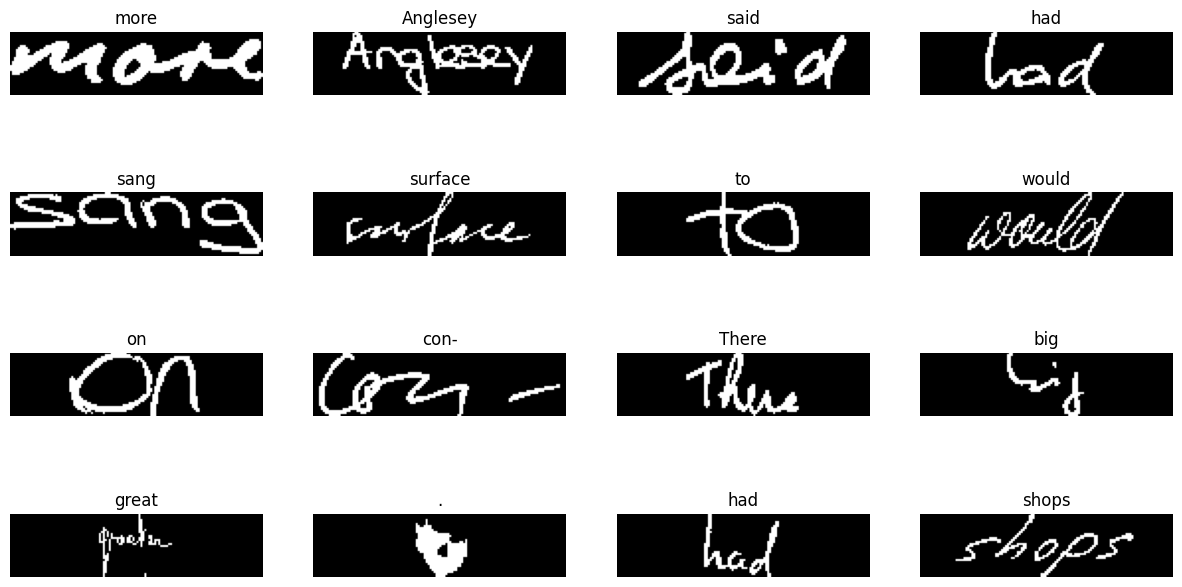

In [16]:
_, subs = plt.subplots(4, 4, figsize=(15, 8))
for img, label, sb in zip(X[:16], Y[:16], subs.ravel()):
    sb.imshow(img, cmap="gray")
    sb.set_title(label)
    sb.axis("off")

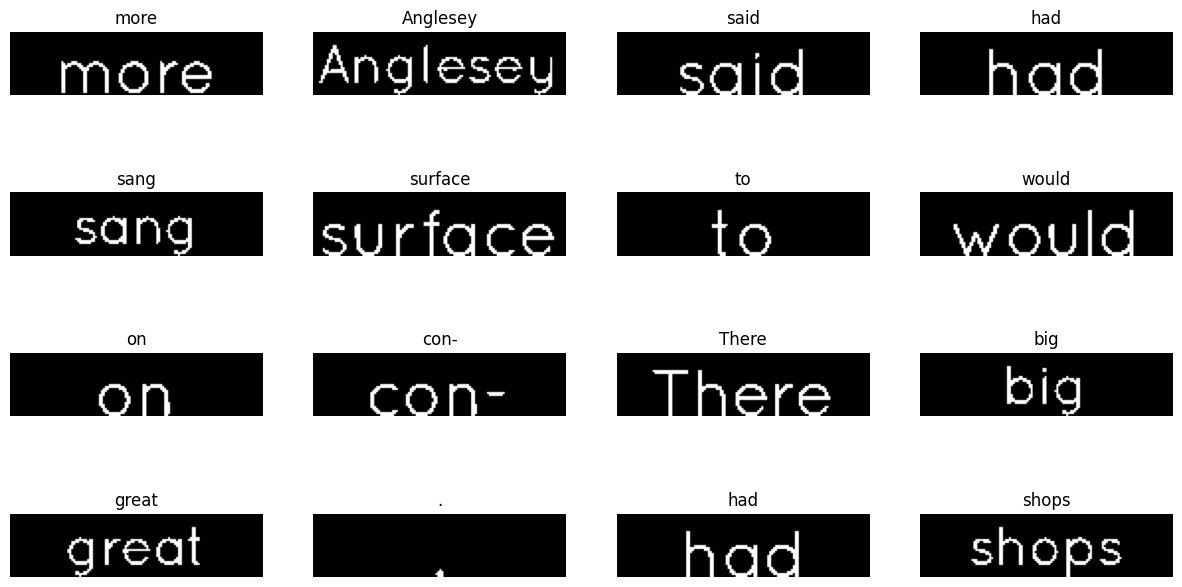

In [17]:
_, subs = plt.subplots(4, 4, figsize=(15, 8))
for img, label, sb in zip(Z[:16], Y[:16], subs.ravel()):
    sb.imshow(img, cmap="gray")
    sb.set_title(label)
    sb.axis("off")